In [1]:
from tsai.all import *
import sklearn.metrics as skm

from IPython.display import clear_output
computer_setup()

c:\Users\lucki\anaconda3\envs\stylegan\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


os              : Windows-10-10.0.22621-SP0
python          : 3.8.15
tsai            : 0.3.4
fastai          : 2.7.10
fastcore        : 1.5.27
torch           : 1.9.1+cu111
device          : 1 gpu (['NVIDIA GeForce RTX 2070 SUPER'])
cpu cores       : 8
threads per cpu : 2
RAM             : 31.92 GB
GPU memory      : [8.0] GB


### Resteaze Data

In [9]:
# Read the data
data = pd.read_csv('final_processed.csv', index_col=0)
data

,ledGreen,accelerometer,gyroscope,sleep_state,bpm,ibi,sdnn,sdsd,rmssd,pnn20,pnn50,hr_mad,sd1,sd2,s,sd1/sd2,breathingrate,hr
0,44.017837,4031.366270,218.972601,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37.23489660640545
1,243.316094,4033.261614,240.587822,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36.14947820780132
2,628.524031,4035.257737,262.429038,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34.80195512238786
3,1037.882909,4039.649737,271.788061,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,33.8155375957624
4,1252.057796,4044.051063,283.347843,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,33.38660268613536
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18362995,22.546209,4045.621244,213.984813,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50.080325
18362996,22.342615,4044.926823,221.867077,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,48.287522
18362997,21.302988,4045.749313,238.856128,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,46.135145
18362998,19.550757,4046.576207,256.132778,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,44.064066


In [10]:
# select the columns
data = data[['ledGreen', 'sleep_state']].interpolate()

In [11]:
data.reset_index(drop=True, inplace=True)

In [12]:
df = data.copy()

In [16]:
df

,ledGreen,sleep_state
0,44.017837,0
1,243.316094,0
2,628.524031,0
3,1037.882909,0
4,1252.057796,0
...,...,...
18362995,22.546209,1
18362996,22.342615,1
18362997,21.302988,1
18362998,19.550757,1


## TSData preparation

## Data from 3d array

In [20]:
from sklearn.preprocessing import MinMaxScaler, RobustScaler, LabelEncoder


scaler = RobustScaler()
le = LabelEncoder()

X = scaler.fit_transform(df[['ledGreen']])
y = le.fit_transform(df['sleep_state'])

# selecting sequences range
X = X[0:(len(X)-len(X)%1500)]
y = y[0:(len(X)-len(y)%1500)]

pd.DataFrame(X)

,0
0,4.818995
1,26.210560
2,67.556634
3,111.494935
4,134.483275
...,...
18362995,2.514350
18362996,2.492497
18362997,2.380909
18362998,2.192835


In [21]:
# epoch lenght 60 seconds (25hz * 60 = 1500)
# 12241 epochs
sht = len(X) // 1500
print("Shape: ", sht)

X = X.T.reshape(sht, 1, 1500)
y = y.T.reshape(sht, 1500)
y = (y.sum(axis=1) // 1500).reshape(-1, 1).flatten()

X.shape, y.shape

Shape:  12242


((12242, 1, 1500), (12242,))

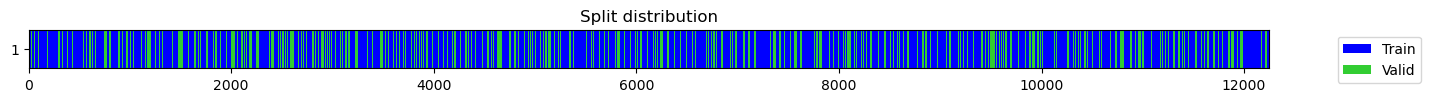

((#8570) [1776,9793,2063,7859,11110,2186,11767,3690,490,10402...],
 (#3672) [2269,3938,3141,6988,793,5465,11561,7456,2833,10732...])

In [38]:
splits = get_splits(y,
                    valid_size=.3,
                    stratify=False,
                    random_state=123,
                    shuffle=True)
splits

In [39]:
tfms = [None, [Categorize()]]
dsets = TSDatasets(X, y, tfms=tfms, splits=splits, inplace=True)

## Dataloaders

In [40]:
dls = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[64, 128], batch_tfms=[TSStandardize()], num_workers=0)

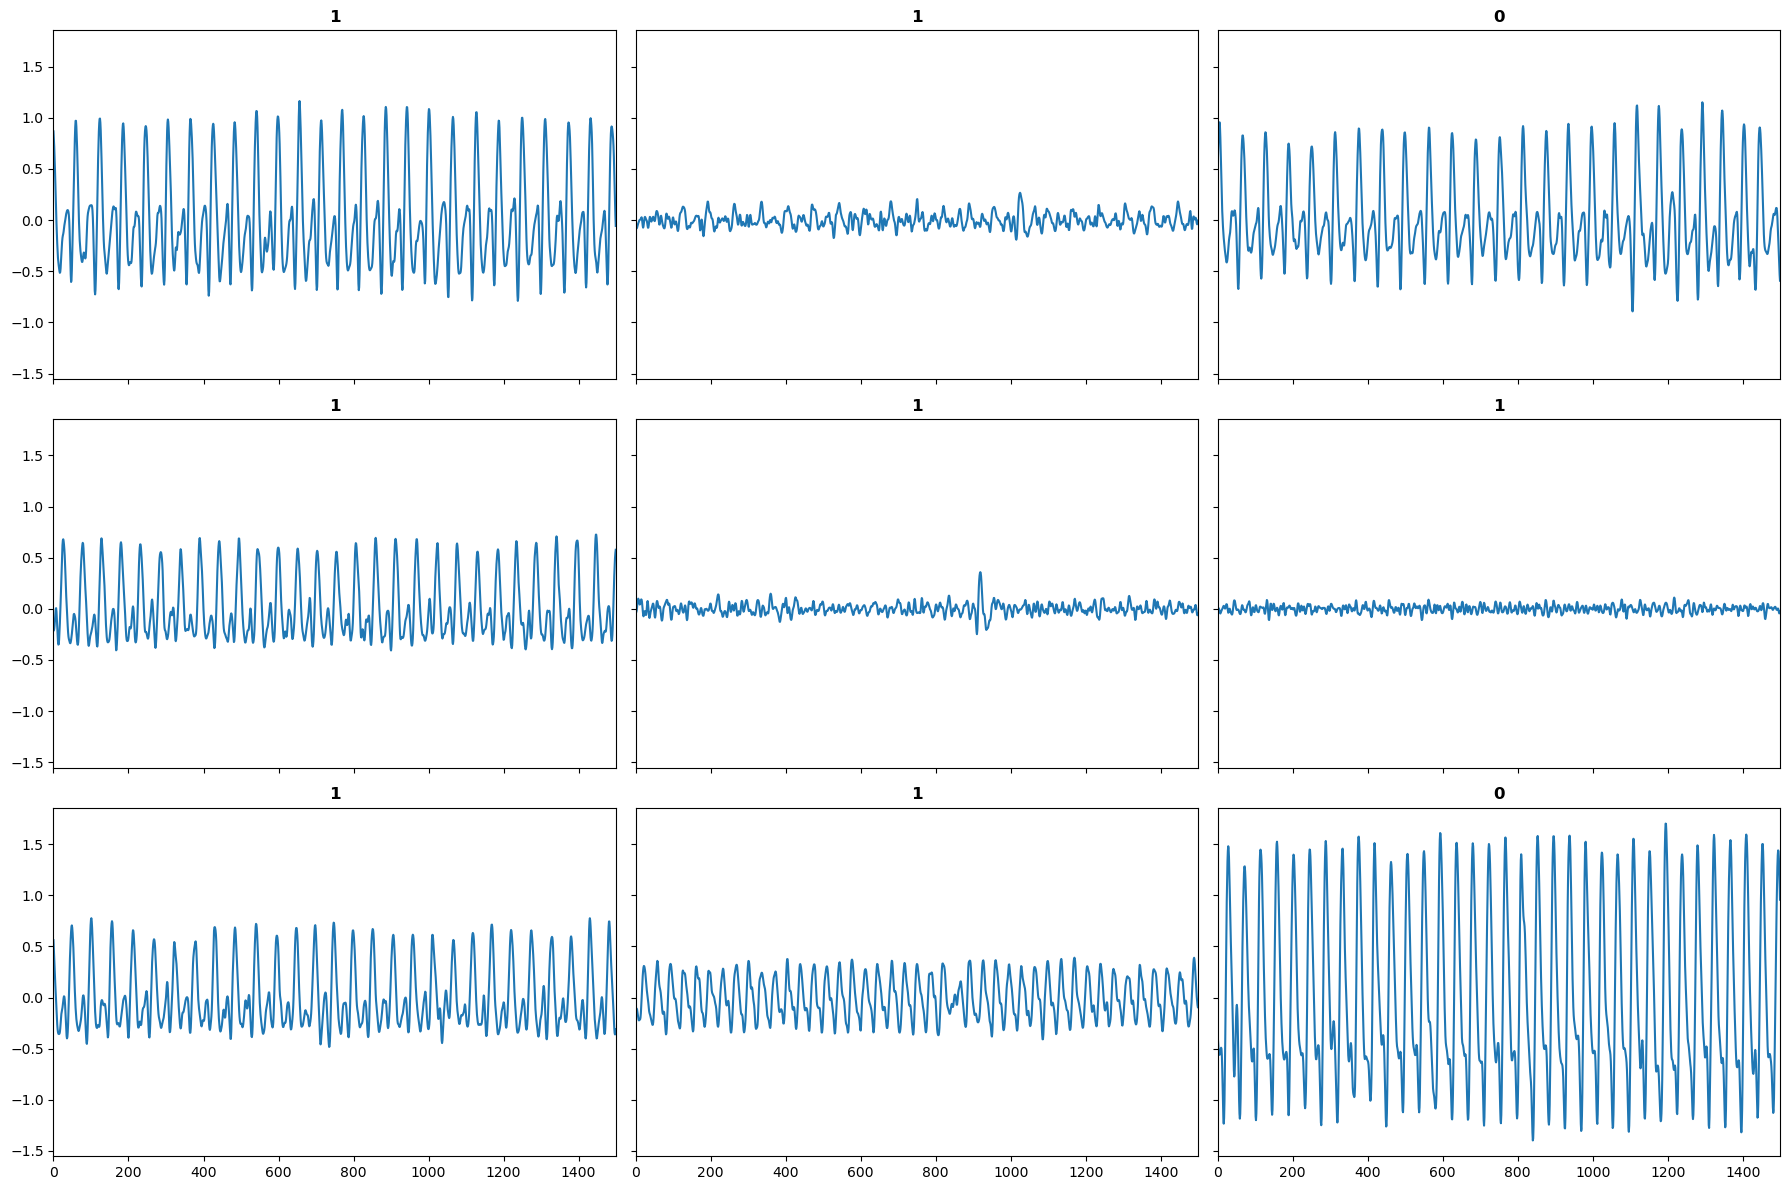

In [41]:
dls.show_batch(sharey=True)

## Build learner

In [49]:
# model = InceptionTime(
#     dls.vars,
#     dls.c,
# )
# learn = Learner(dls, model, metrics=accuracy)
# learn.save('stage0')

In [50]:
archs = [(FCN, {}), (ResNet, {}), (xresnet1d34, {}), (ResCNN, {}),
         (LSTM, {'n_layers':1, 'bidirectional': False}), (LSTM, {'n_layers':2, 'bidirectional': False}), (LSTM, {'n_layers':3, 'bidirectional': False}),
         (LSTM, {'n_layers':1, 'bidirectional': True}), (LSTM, {'n_layers':2, 'bidirectional': True}), (LSTM, {'n_layers':3, 'bidirectional': True}),
         (LSTM_FCN, {}), (LSTM_FCN, {'shuffle': False}), (InceptionTime, {}), (XceptionTime, {}), (OmniScaleCNN, {}), (mWDN, {'levels': 4})]


for i, (arch, k) in enumerate(archs):
    print(f'arch: {arch.__name__}')

# results = pd.DataFrame(columns=['arch', 'hyperparams', 'total params', 'train loss', 'valid loss', 'accuracy', 'time'])
# for i, (arch, k) in enumerate(archs):
#     model = create_model(arch, dls=dls, **k)
#     print(model.__class__.__name__)
#     learn = Learner(dls, model,  metrics=accuracy)
#     start = time.time()
#     learn.fit_one_cycle(10, 1e-3)
#     elapsed = time.time() - start
#     vals = learn.recorder.values[-1]
#     results.loc[i] = [arch.__name__, k, count_parameters(model), vals[0], vals[1], vals[2], int(elapsed)]
#     results.sort_values(by='accuracy', ascending=False, ignore_index=True, inplace=True)
#     clear_output()
#     display(results)

arch: FCN
arch: ResNet
arch: xresnet1d34
arch: ResCNN
arch: LSTM
arch: LSTM
arch: LSTM
arch: LSTM
arch: LSTM
arch: LSTM
arch: LSTM_FCN
arch: LSTM_FCN
arch: InceptionTime
arch: XceptionTime
arch: OmniScaleCNN
arch: mWDN


In [51]:
model = create_model(LSTM, dls=dls, **{})

In [52]:
learn = Learner(dls, model, metrics=accuracy)

## LR find

SuggestedLRs(valley=0.004365158267319202)

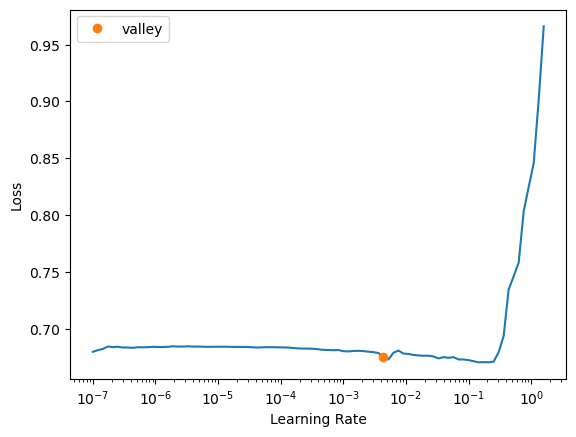

In [53]:
# learn.load('stage0')
learn.lr_find()

In [54]:
learn.fit_one_cycle(25, lr_max=1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.670535,0.660194,0.649510,00:19
1,0.650466,0.642098,0.652233,00:19
2,0.638404,0.614865,0.692810,00:19
3,0.577720,0.559851,0.742375,00:19
4,0.558669,0.553822,0.755719,00:19
5,0.547994,0.552438,0.757625,00:19
6,0.556323,0.545413,0.758715,00:19
7,0.565675,0.554805,0.754357,00:19
8,0.550190,0.550811,0.757081,00:19
9,0.563445,0.565559,0.747004,00:19


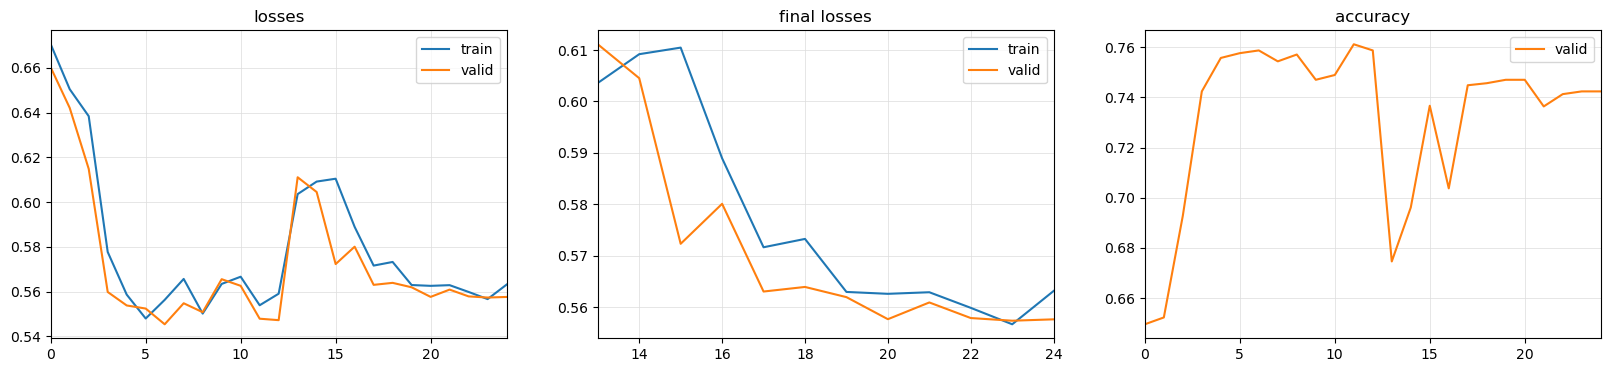

In [55]:
learn.plot_metrics()

In [56]:
learn.save('stage1')

Path('models/stage1.pth')

In [57]:
learn.save_all(path='export_uni',
               dls_fname='dls',
               model_fname='model',
               learner_fname='learner')

## Inferece


In [58]:
# learn = load_learner_all(path='export',
#                          dls_fname='dls',
#                          model_fname='model',
#                          learner_fname='learner')

dls = learn.dls
valid_dl = dls.valid
b = next(iter(valid_dl))
b

(TSTensor(samples:128, vars:1, len:1500, device=cuda:0, dtype=torch.float32),
 TensorCategory([0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1,
         1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1,
         1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1,
         0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1,
         0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0,
         0, 1, 0, 1, 0, 1, 1, 0], device='cuda:0'))

In [59]:
valid_probas, valid_targets, valid_preds = learn.get_preds(dl=valid_dl,
                                                           with_decoded=True)
valid_probas, valid_targets, valid_preds

(tensor([[0.6202, 0.3798],
         [0.2150, 0.7850],
         [0.2203, 0.7797],
         ...,
         [0.2567, 0.7433],
         [0.2353, 0.7647],
         [0.2229, 0.7771]]),
 tensor([0, 0, 1,  ..., 1, 1, 1]),
 tensor([0, 1, 1,  ..., 1, 1, 1]))

In [60]:
(valid_targets == valid_preds).float().mean()

tensor(0.7424)

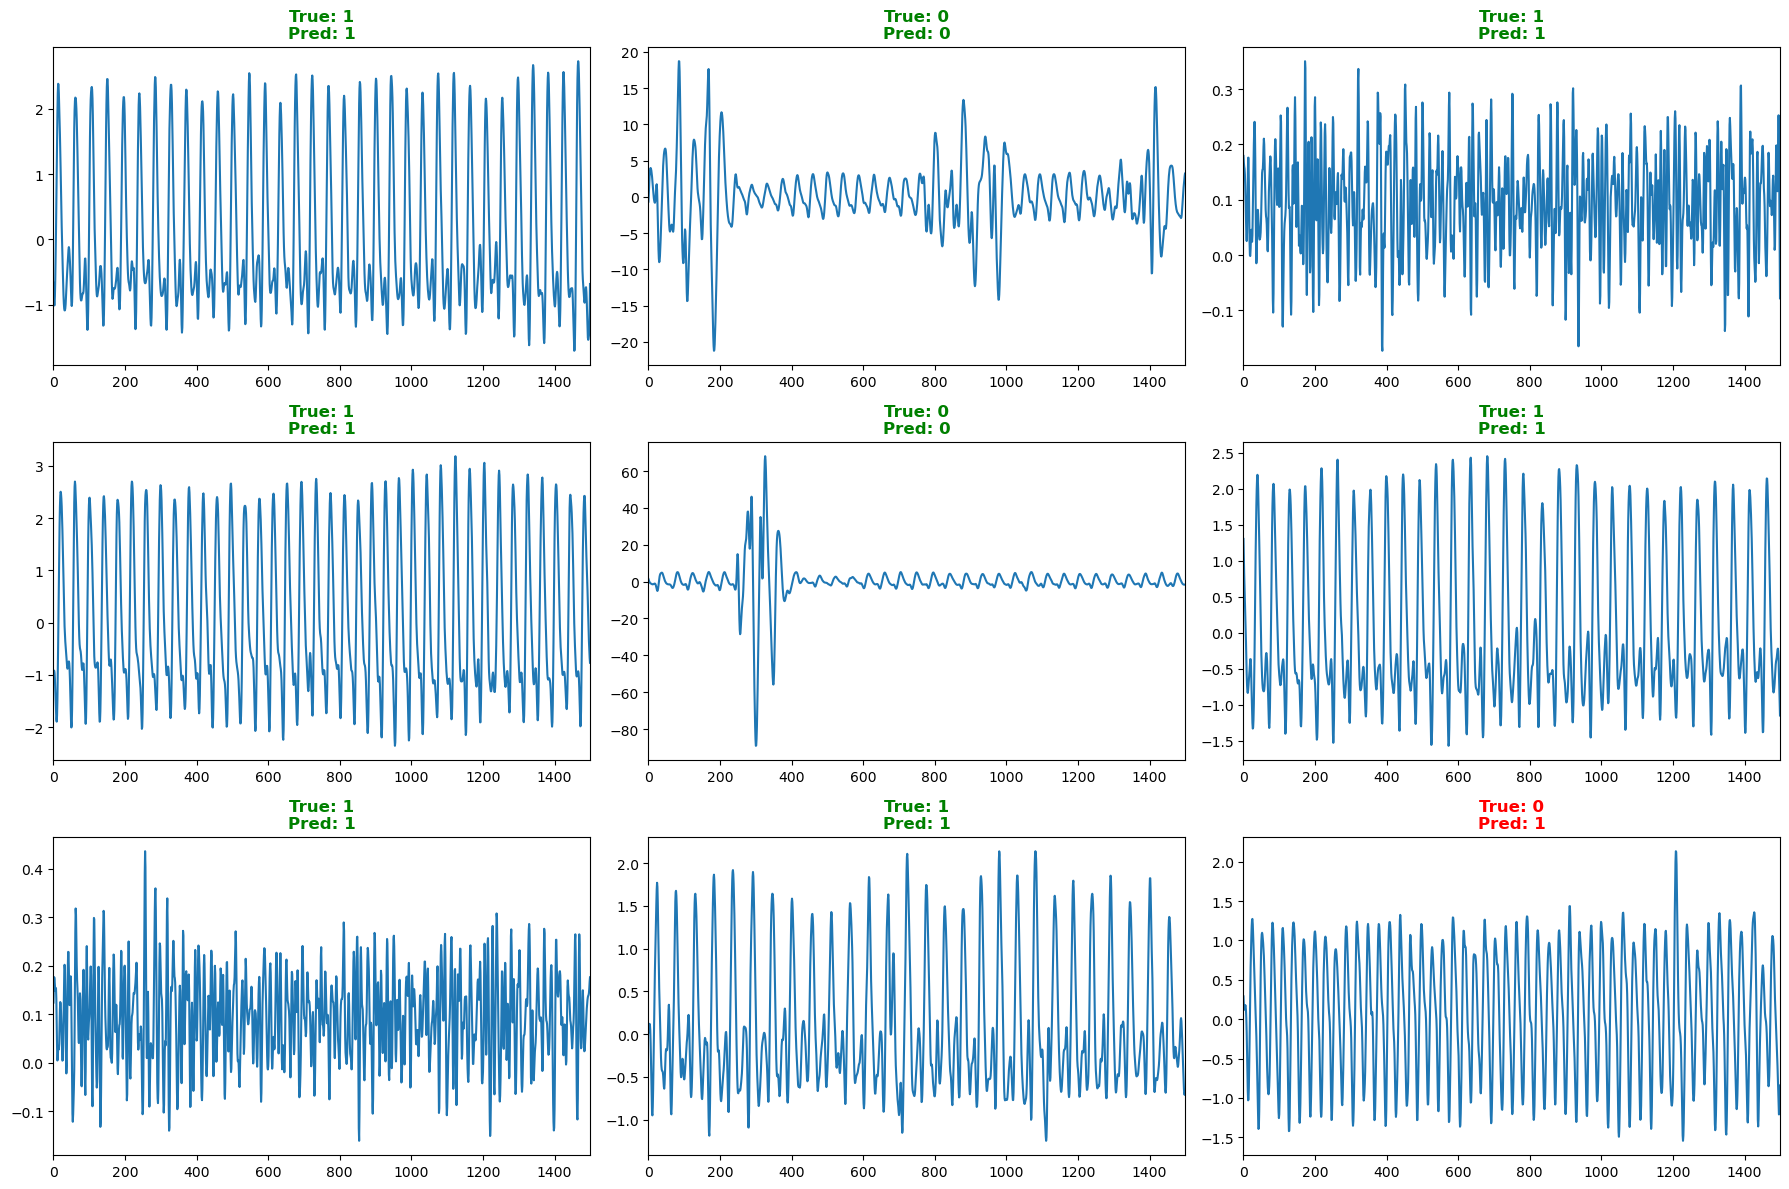

In [61]:
learn.show_results()


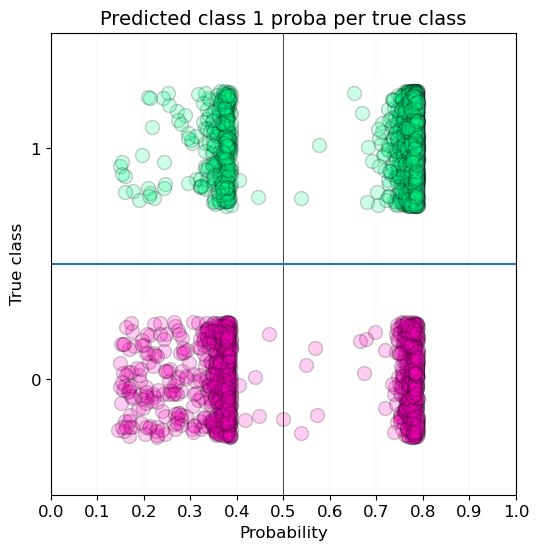

In [62]:
learn.show_probas()


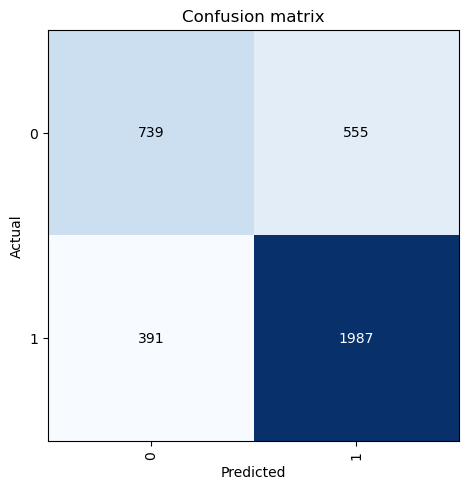

In [63]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()


In [64]:
interp.most_confused(min_val=3)

[(0, 1, 555), (1, 0, 391)]

In [65]:
print(f'accuracy: {skm.accuracy_score(valid_targets, valid_preds):10.6f}')

accuracy:   0.742375


# inference on unseen data

In [66]:
# Read the data
test_data = pd.read_csv('final_test_processed.csv', index_col=0)

# select the columns
test_data = test_data[['ledGreen', 'sleep_state']].interpolate()

test_data.reset_index(drop=True, inplace=True)

In [67]:
test_data

,ledGreen,sleep_state
0,81.099061,0
1,448.425521,0
2,1158.939516,0
3,1915.355496,0
4,2313.691734,0
...,...,...
2138995,2.509672,1
2138996,5.263592,1
2138997,7.742607,1
2138998,9.844872,1


In [68]:
scaler = RobustScaler()
le = LabelEncoder()

X_test = scaler.fit_transform(test_data[['ledGreen']])
y_test = le.fit_transform(test_data['sleep_state'])

pd.DataFrame(X_test)

,0
0,4.885208
1,26.556813
2,68.475869
3,113.103059
4,136.604185
...,...
2138995,0.248575
2138996,0.411051
2138997,0.557309
2138998,0.681339


In [71]:
# epoch lenght 60 seconds (25hz * 60 = 1500)
sh = len(X_test)//1500 

X_test = X_test.T.reshape(sh, 1, 1500)
y_test = y_test.T.reshape(sh, 1500)
y_test = (y_test.sum(axis=1) // 1500).reshape(-1, 1).flatten()

X_test.shape, y_test.shape

((1426, 1, 1500), (1426,))

In [72]:
# Labelled test data
test_ds = valid_dl.dataset.add_test(
    X_test, y_test)  # In this case I'll use X and y, but this would be your test data
test_dl = valid_dl.new(test_ds)
next(iter(test_dl))

(TSTensor(samples:128, vars:1, len:1500, device=cuda:0, dtype=torch.float32),
 TensorCategory([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0'))

In [73]:
test_probas, test_targets, test_preds = learn.get_preds(dl=test_dl,
                                                        with_decoded=True,
                                                        save_preds=None,
                                                        save_targs=None)
test_probas, test_targets, test_preds


(tensor([[0.6199, 0.3801],
         [0.2116, 0.7884],
         [0.2114, 0.7886],
         ...,
         [0.2142, 0.7858],
         [0.2164, 0.7836],
         [0.2142, 0.7858]]),
 tensor([0, 0, 0,  ..., 1, 1, 1]),
 tensor([0, 1, 1,  ..., 1, 1, 1]))

In [74]:
print(f'accuracy: {skm.accuracy_score(test_targets, test_preds):10.6f}')

accuracy:   0.668303


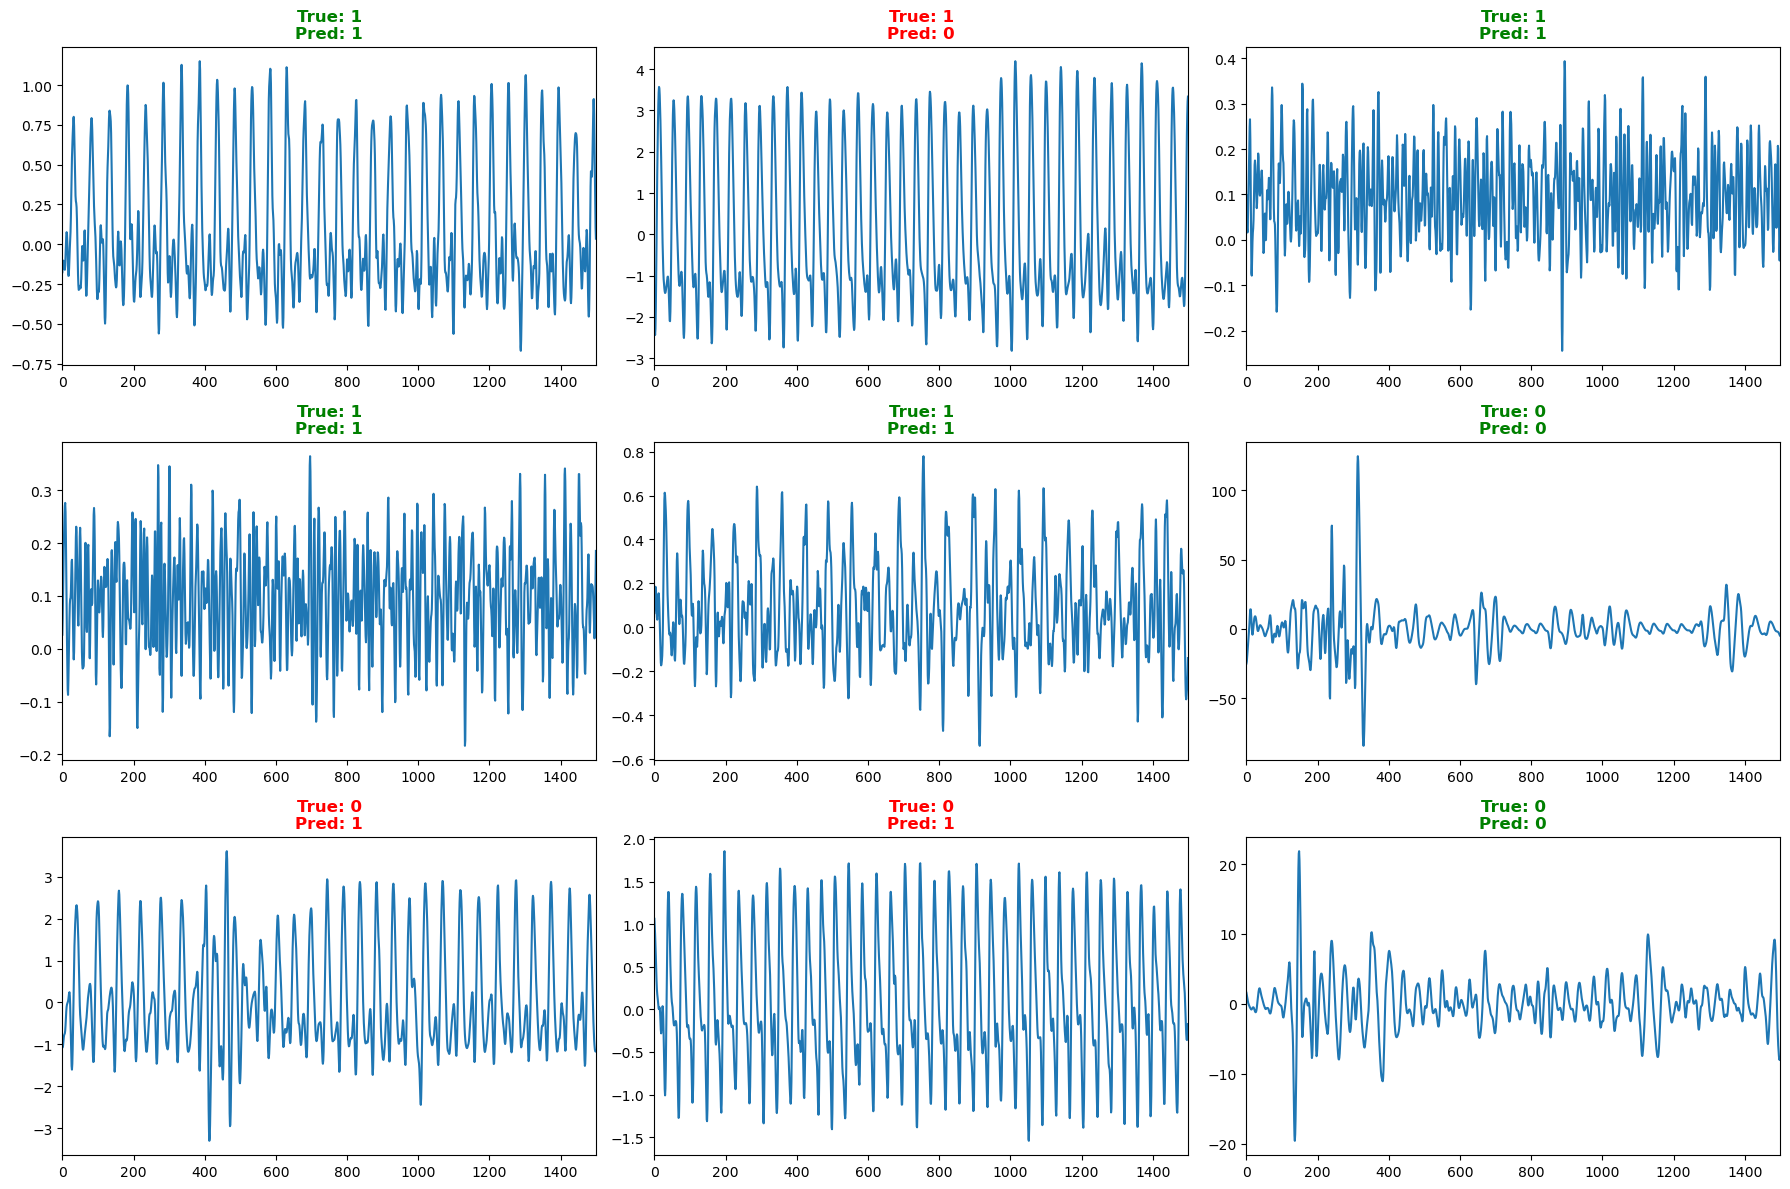

In [75]:
learn.show_results()


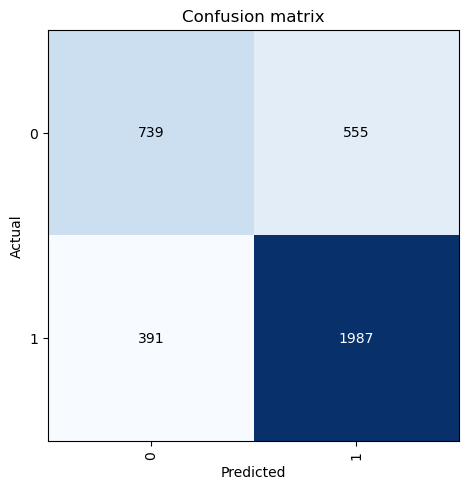

In [76]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

#### If unlabelled data

In [ ]:
# Unlabelled data
test_ds = dls.dataset.add_test(X)
test_dl = valid_dl.new(test_ds)
next(iter(test_dl))

In [ ]:
test_probas, *_ = learn.get_preds(dl=test_dl, save_preds=None)
test_probas
